ML Conversion Prediction – Marketing Analytics
Source des données : PostgreSQL (sessions + events)

Objectif :
- Prédire la probabilité de conversion d’un utilisateur
- Identifier les facteurs clés de conversion
- Comparer plusieurs modèles ML (RF, XGBoost)

Pipeline :
PostgreSQL → SQL Feature Engineering → Pandas → ML


In [24]:
"""
Modèle ML de Prédiction de Conversion Utilisateur
Objectif: Prédire si un utilisateur va convertir basé sur son comportement
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

print(" Imports chargés")



 Imports chargés


In [4]:
def load_data_from_postgres():
    conn = psycopg2.connect(
        dbname="TP3_DB",
        user="postgres",
        password="0000",
        host="localhost",
        port="5432"
    )

    query = """
    SELECT
        s.session_id,
        EXTRACT(EPOCH FROM (s.end_time - s.start_time))/60 AS time_on_site,
        s.pages_viewed,
        s.channel AS source,
        COALESCE(e.properties->>'device','unknown') AS device,
        EXTRACT(HOUR FROM s.start_time) AS hour_of_day,
        EXTRACT(DOW FROM s.start_time) AS day_of_week,
        COUNT(e.event_id) AS total_events,
        COUNT(CASE WHEN e.event_type='add_to_cart' THEN 1 END) AS add_to_cart_count,
        COUNT(CASE WHEN e.event_type='page_view' THEN 1 END) AS page_view_count,
        s.converted::int AS converted
    FROM sessions s
    LEFT JOIN events e ON s.user_id = e.user_id
    GROUP BY
        s.session_id, s.start_time, s.end_time,
        s.pages_viewed, s.channel, device, s.converted
    """

    df = pd.read_sql(query, conn)
    conn.close()
    return df

df = load_data_from_postgres()

print(f" Lignes : {len(df)}")
print(f" Taux de conversion : {df['converted'].mean():.2%}")
df.head()


 Lignes : 10028
 Taux de conversion : 31.64%


,session_id,time_on_site,pages_viewed,source,device,hour_of_day,day_of_week,total_events,add_to_cart_count,page_view_count,converted
0,sess_000000,7.0,5,organic,unknown,15.0,2.0,5,2,2,0
1,sess_000001,3.0,7,paid,unknown,18.0,0.0,12,4,5,1
2,sess_000002,31.0,3,paid,unknown,14.0,2.0,7,2,3,1
3,sess_000003,6.0,2,paid,unknown,10.0,2.0,11,3,5,1
4,sess_000004,21.0,7,organic,unknown,9.0,1.0,9,4,4,0


ANALYSE EXPLORATOIRE DES DONNÉES

 Statistiques descriptives:
       time_on_site  pages_viewed   hour_of_day   day_of_week  total_events  \
count  10028.000000  10028.000000  10028.000000  10028.000000  10028.000000   
mean      20.360690      3.005584     11.662445      2.877044      8.101416   
std       11.721164      1.664958      6.894121      2.054542      3.716087   
min     -172.000000      1.000000      0.000000      0.000000      1.000000   
25%       10.000000      2.000000      6.000000      1.000000      5.000000   
50%       20.000000      3.000000     12.000000      3.000000      8.000000   
75%       30.000000      4.000000     18.000000      5.000000     10.000000   
max       85.000000     12.000000     23.000000      6.000000     25.000000   

       add_to_cart_count  page_view_count     converted  
count       10028.000000     10028.000000  10028.000000  
mean            2.402673         4.322696      0.316414  
std             1.454335         1.809402      0.465

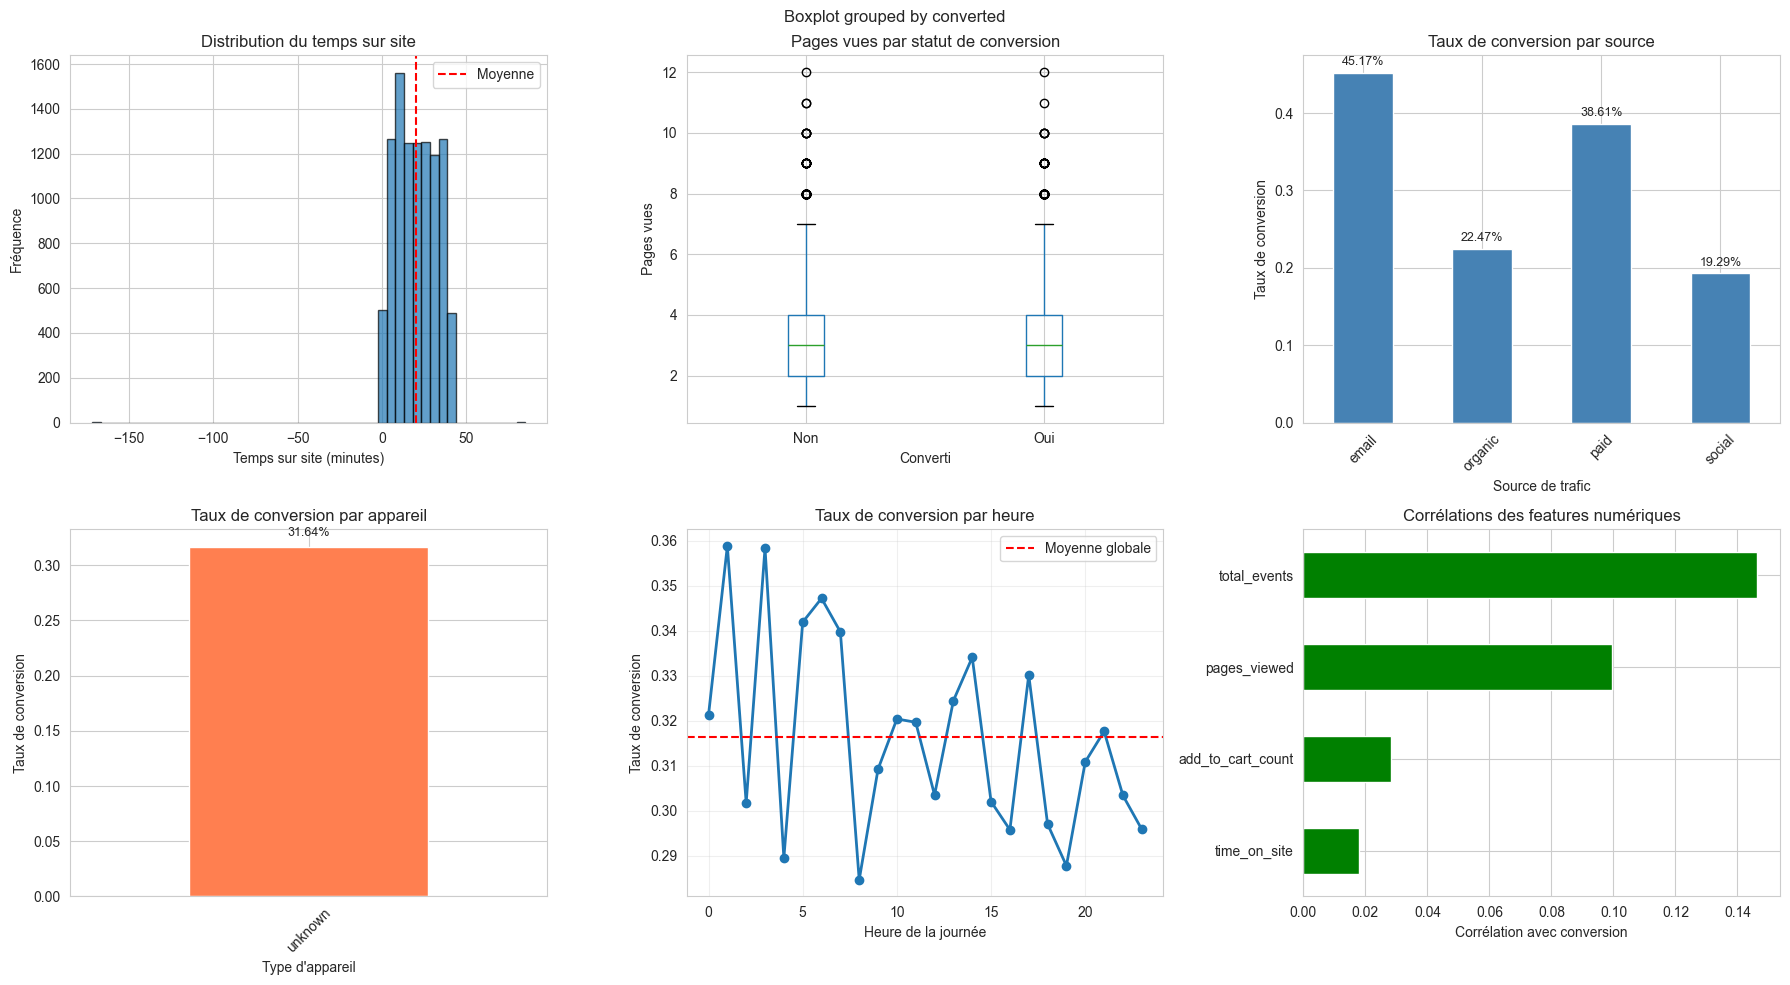


 Graphiques EDA sauvegardés: eda_analysis.png


In [5]:
"""
Analyse exploratoire des données
"""

print("="*60)
print("ANALYSE EXPLORATOIRE DES DONNÉES")
print("="*60)

# Statistiques descriptives
print("\n Statistiques descriptives:")
print(df.describe())

print("\n Types de données:")
print(df.dtypes)

print("\n Valeurs manquantes:")
print(df.isnull().sum())

print("\n Distribution de la target:")
print(df['converted'].value_counts())
print(f"\nProportions:")
print(df['converted'].value_counts(normalize=True))

# Visualisations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution du temps sur site
axes[0, 0].hist(df['time_on_site'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Temps sur site (minutes)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution du temps sur site')
axes[0, 0].axvline(df['time_on_site'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0, 0].legend()

# 2. Pages vues par conversion
df.boxplot(column='pages_viewed', by='converted', ax=axes[0, 1])
axes[0, 1].set_xlabel('Converti')
axes[0, 1].set_ylabel('Pages vues')
axes[0, 1].set_title('Pages vues par statut de conversion')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Non', 'Oui'])

# 3. Taux de conversion par source
conv_by_source = df.groupby('source')['converted'].agg(['mean', 'count'])
conv_by_source['mean'].plot(kind='bar', ax=axes[0, 2], color='steelblue')
axes[0, 2].set_xlabel('Source de trafic')
axes[0, 2].set_ylabel('Taux de conversion')
axes[0, 2].set_title('Taux de conversion par source')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(conv_by_source['mean']):
    axes[0, 2].text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=9)

# 4. Taux de conversion par device
conv_by_device = df.groupby('device')['converted'].agg(['mean', 'count'])
conv_by_device['mean'].plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_xlabel('Type d\'appareil')
axes[1, 0].set_ylabel('Taux de conversion')
axes[1, 0].set_title('Taux de conversion par appareil')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(conv_by_device['mean']):
    axes[1, 0].text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=9)

# 5. Conversion par heure
conv_by_hour = df.groupby('hour_of_day')['converted'].mean()
axes[1, 1].plot(conv_by_hour.index, conv_by_hour.values, marker='o', linewidth=2)
axes[1, 1].set_xlabel('Heure de la journée')
axes[1, 1].set_ylabel('Taux de conversion')
axes[1, 1].set_title('Taux de conversion par heure')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(df['converted'].mean(), color='red', linestyle='--', label='Moyenne globale')
axes[1, 1].legend()

# 6. Corrélation avec la conversion
numeric_cols = ['time_on_site', 'pages_viewed', 'total_events', 'add_to_cart_count']
correlations = df[numeric_cols + ['converted']].corr()['converted'].drop('converted').sort_values()
correlations.plot(kind='barh', ax=axes[1, 2], color='green')
axes[1, 2].set_xlabel('Corrélation avec conversion')
axes[1, 2].set_title('Corrélations des features numériques')
axes[1, 2].axvline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Graphiques EDA sauvegardés: eda_analysis.png")

In [7]:
"""
Création de nouvelles features pour améliorer le modèle
"""

def engineer_features(df):
    """
    Crée des features dérivées à partir des features existantes
    """
    df = df.copy()

    print(" Feature Engineering en cours...")

    # 1. Métriques d'engagement
    df['time_per_page'] = df['time_on_site'] / (df['pages_viewed'] + 1)
    df['events_per_minute'] = df['total_events'] / (df['time_on_site'] + 1)

    # 2. Score d'engagement composite
    df['engagement_score'] = (
        df['time_on_site'] * 0.3 +
        df['pages_viewed'] * 0.3 +
        df['add_to_cart_count'] * 2.0 +
        df['total_events'] * 0.2
    )

    # 3. Features temporelles
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_business_hours'] = ((df['hour_of_day'] >= 9) & (df['hour_of_day'] <= 17)).astype(int)
    df['is_evening'] = ((df['hour_of_day'] >= 18) & (df['hour_of_day'] <= 23)).astype(int)

    # 4. Features d'interaction
    df['high_engagement_paid'] = ((df['source'] == 'paid') & (df['engagement_score'] > df['engagement_score'].median())).astype(int)
    df['mobile_quick_session'] = ((df['device'] == 'mobile') & (df['time_on_site'] < 2)).astype(int)

    # 5. Indicateurs comportementaux
    df['has_added_to_cart'] = (df['add_to_cart_count'] > 0).astype(int)
    df['high_page_views'] = (df['pages_viewed'] > df['pages_viewed'].quantile(0.75)).astype(int)
    df['long_session'] = (df['time_on_site'] > df['time_on_site'].quantile(0.75)).astype(int)

    print(f" Features créées: {df.shape[1]} features au total")

    return df

# Application du feature engineering
df_engineered = engineer_features(df)

print("\n Nouvelles features créées:")
new_features = [col for col in df_engineered.columns if col not in df.columns]
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

# Afficher un échantillon
print("\n Échantillon des données enrichies:")
print(df_engineered.head())

 Feature Engineering en cours...
 Features créées: 22 features au total

 Nouvelles features créées:
  1. time_per_page
  2. events_per_minute
  3. engagement_score
  4. is_weekend
  5. is_business_hours
  6. is_evening
  7. high_engagement_paid
  8. mobile_quick_session
  9. has_added_to_cart
  10. high_page_views
  11. long_session

 Échantillon des données enrichies:
    session_id  time_on_site  pages_viewed   source   device  hour_of_day  \
0  sess_000000           7.0             5  organic  unknown         15.0   
1  sess_000001           3.0             7     paid  unknown         18.0   
2  sess_000002          31.0             3     paid  unknown         14.0   
3  sess_000003           6.0             2     paid  unknown         10.0   
4  sess_000004          21.0             7  organic  unknown          9.0   

   day_of_week  total_events  add_to_cart_count  page_view_count  ...  \
0          2.0             5                  2                2  ...   
1          0.0    

In [12]:
"""
Encodage et normalisation des données
"""

# Séparer features et target
X = df_engineered.drop('converted', axis=1)
y = df_engineered['converted']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Identifier les features catégorielles et numériques
categorical_features = ['source', 'device']
numeric_features = [col for col in X.columns if col not in categorical_features]

print(f"\n Features catégorielles ({len(categorical_features)}): {categorical_features}")
print(f" Features numériques ({len(numeric_features)}): {len(numeric_features)}")

# Encoder les variables catégorielles (One-Hot Encoding)
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"\n Données encodées: {X_encoded.shape}")
print(f" Nouvelles colonnes après encoding: {X_encoded.shape[1]} features")

# Split train/test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train = X_train.drop(columns=['session_id'])
X_test = X_test.drop(columns=['session_id'])

bool_cols = X_train.select_dtypes(include='bool').columns

X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)


print(f"\n Distribution des données:")
print(f"  • Training set: {len(X_train)} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"  • Test set: {len(X_test)} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"\n Taux de conversion:")
print(f"  • Training: {y_train.mean():.2%}")
print(f"  • Test: {y_test.mean():.2%}")

# Normalisation (pour Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Normalisation effectuée (pour Logistic Regression)")

Features (X): (10028, 21)
Target (y): (10028,)

 Features catégorielles (2): ['source', 'device']
 Features numériques (19): 19

 Données encodées: (10028, 22)
 Nouvelles colonnes après encoding: 22 features

 Distribution des données:
  • Training set: 8022 samples (80.0%)
  • Test set: 2006 samples (20.0%)

 Taux de conversion:
  • Training: 31.64%
  • Test: 31.66%

 Normalisation effectuée (pour Logistic Regression)


In [13]:
print(X_train.dtypes)


time_on_site            float64
pages_viewed              int64
hour_of_day             float64
day_of_week             float64
total_events              int64
add_to_cart_count         int64
page_view_count           int64
time_per_page           float64
events_per_minute       float64
engagement_score        float64
is_weekend                int32
is_business_hours         int32
is_evening                int32
high_engagement_paid      int32
mobile_quick_session      int32
has_added_to_cart         int32
high_page_views           int32
long_session              int32
source_organic            int32
source_paid               int32
source_social             int32
dtype: object


Modèle 1 - Random Forest

In [15]:
"""
Entraînement et évaluation du modèle Random Forest
"""

print("="*60)
print("MODÈLE 2: RANDOM FOREST")
print("="*60)

# Entraînement
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Métriques
print("\n MÉTRIQUES DE PERFORMANCE:")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  • F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"  • AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf,
                          target_names=['Non converti', 'Converti']))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n Top 10 Features importantes:")
print(feature_importance_rf.head(10).to_string(index=False))

MODÈLE 2: RANDOM FOREST

 MÉTRIQUES DE PERFORMANCE:
  • Accuracy: 0.7343
  • Precision: 0.6711
  • Recall: 0.3150
  • F1-Score: 0.4287
  • AUC-ROC: 0.7633

 Classification Report:
              precision    recall  f1-score   support

Non converti       0.75      0.93      0.83      1371
    Converti       0.67      0.31      0.43       635

    accuracy                           0.73      2006
   macro avg       0.71      0.62      0.63      2006
weighted avg       0.72      0.73      0.70      2006


 Top 10 Features importantes:
          feature  importance
 engagement_score    0.117914
events_per_minute    0.117453
     total_events    0.109054
    time_per_page    0.099464
      hour_of_day    0.088573
  page_view_count    0.088438
     time_on_site    0.085978
      day_of_week    0.059526
add_to_cart_count    0.050668
     pages_viewed    0.043977


Modèle 2 - XGBoost

In [17]:
print("="*60)
print("MODÈLE 3: XGBOOST (GRADIENT BOOSTING OPTIMISÉ)")
print("="*60)

# Calcul du scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Modèle XGBoost avec paramètres optimisés
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'  # Plus rapide
)

# Entraînement sans early stopping (car le paramètre n'est plus supporté directement)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n MÉTRIQUES DE PERFORMANCE:")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"  • F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"  • AUC-ROC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb,
                          target_names=['Non converti', 'Converti']))

# Feature importance XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Features importantes (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Afficher le meilleur score d'itération
# xgb_model.best_iteration et xgb_model.best_score ne sont pas disponibles sans early_stopping_rounds
# print(f"\n Meilleure itération: {xgb_model.best_iteration}")
# print(f" Meilleur score: {xgb_model.best_score:.4f}")

MODÈLE 3: XGBOOST (GRADIENT BOOSTING OPTIMISÉ)

 MÉTRIQUES DE PERFORMANCE:
  • Accuracy: 0.7463
  • Precision: 0.5833
  • Recall: 0.6945
  • F1-Score: 0.6341
  • AUC-ROC: 0.8171

 Classification Report:
              precision    recall  f1-score   support

Non converti       0.84      0.77      0.81      1371
    Converti       0.58      0.69      0.63       635

    accuracy                           0.75      2006
   macro avg       0.71      0.73      0.72      2006
weighted avg       0.76      0.75      0.75      2006


 Top 10 Features importantes (XGBoost):
          feature  importance
    source_social    0.140868
   source_organic    0.099207
     total_events    0.090668
  page_view_count    0.085395
add_to_cart_count    0.075409
has_added_to_cart    0.074753
  high_page_views    0.037589
     pages_viewed    0.037012
events_per_minute    0.034126
 engagement_score    0.034004


COMPARAISON DES MODÈLES

         Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Random Forest  0.734297   0.671141 0.314961  0.428725 0.763275
      XGBoost  0.746261   0.583333 0.694488  0.634076 0.817113


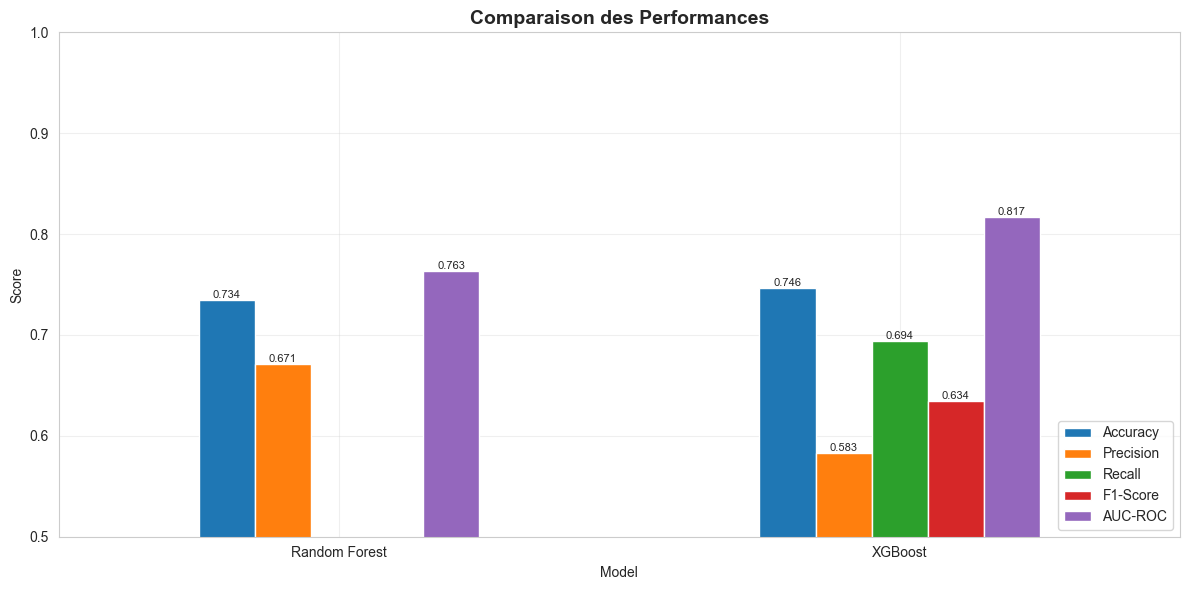


 MEILLEUR MODÈLE: XGBoost
   AUC-ROC: 0.8171


In [18]:
print("="*60)
print("COMPARAISON DES MODÈLES")
print("="*60)

comparison_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(
    kind='bar', ax=ax, rot=0
)
ax.set_ylabel('Score')
ax.set_title('Comparaison des Performances', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

best_model_idx = comparison_df['AUC-ROC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_auc = comparison_df.loc[best_model_idx, 'AUC-ROC']

print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   AUC-ROC: {best_auc:.4f}")

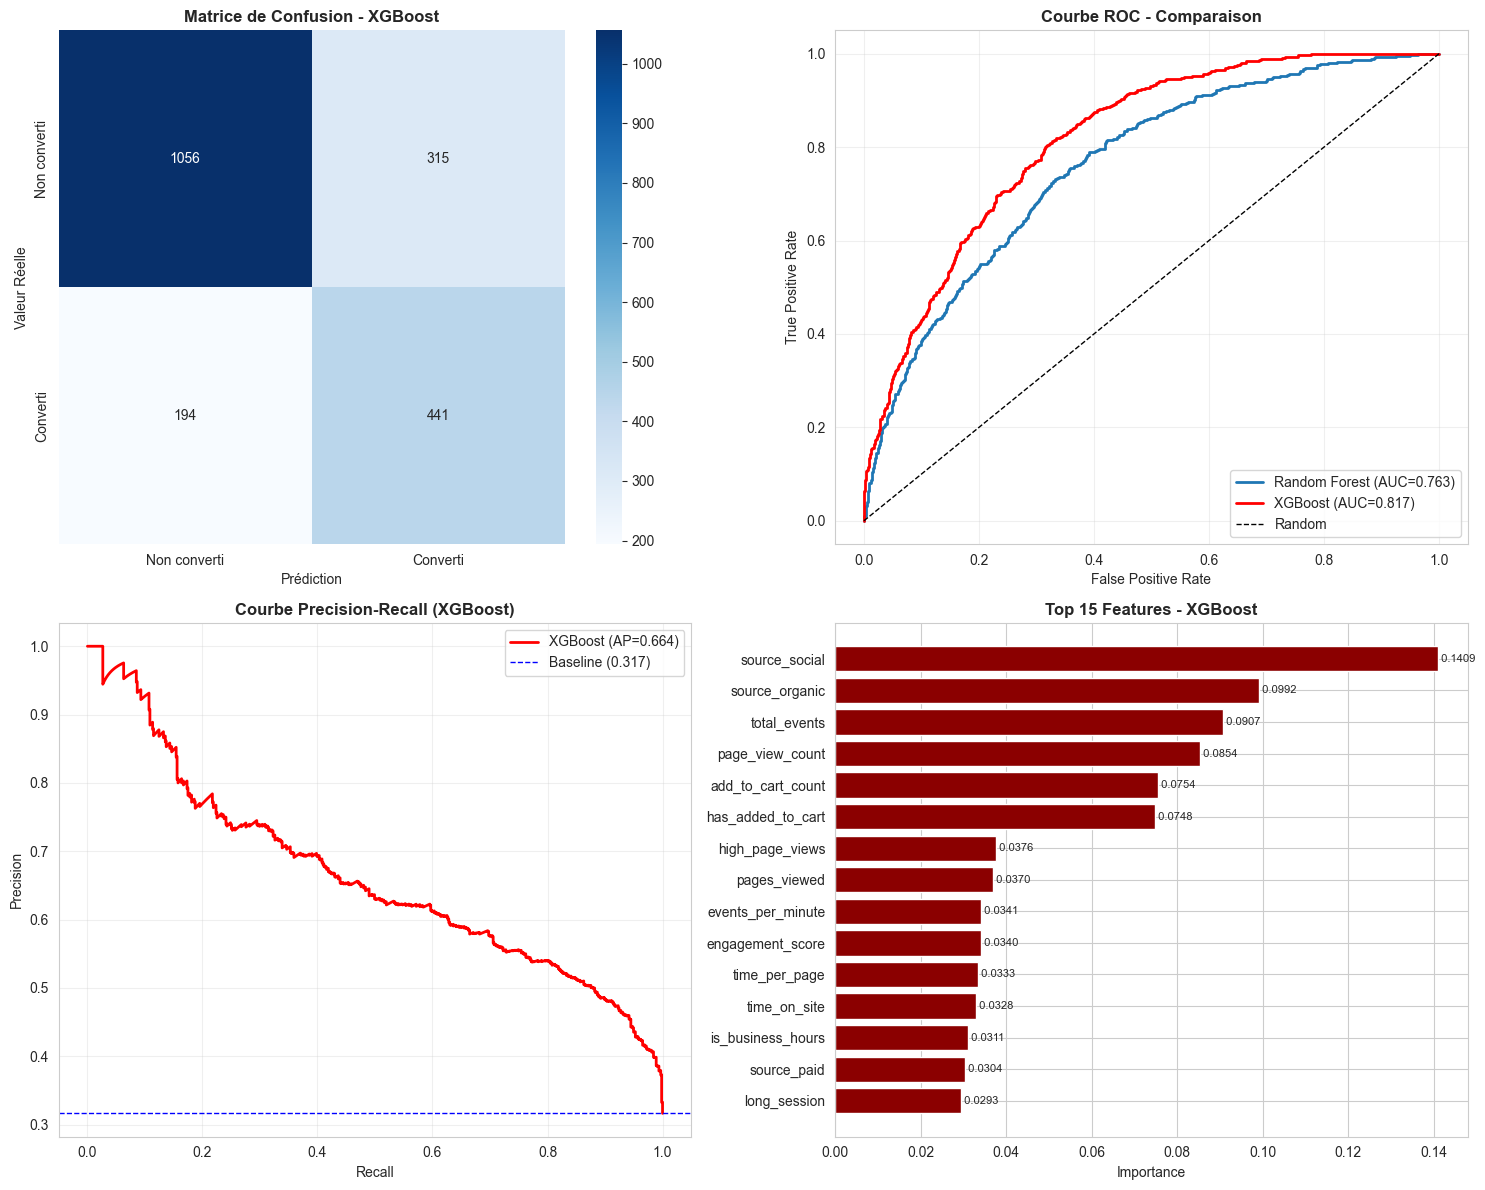

 Visualisations XGBoost sauvegardées


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matrice de Confusion
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non converti', 'Converti'],
            yticklabels=['Non converti', 'Converti'])
axes[0, 0].set_title('Matrice de Confusion - XGBoost', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Valeur Réelle')
axes[0, 0].set_xlabel('Prédiction')

# 2. ROC Curve - Comparaison des 3 modèles
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[0, 1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
axes[0, 1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2, color='red')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Courbe ROC - Comparaison', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
avg_precision = average_precision_score(y_test, y_pred_proba_xgb)

axes[1, 0].plot(recall_xgb, precision_xgb, label=f'XGBoost (AP={avg_precision:.3f})',
                linewidth=2, color='red')
axes[1, 0].axhline(y=y_test.mean(), color='blue', linestyle='--',
                   label=f'Baseline ({y_test.mean():.3f})', linewidth=1)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Courbe Precision-Recall (XGBoost)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance XGBoost (Top 15)
top_features = feature_importance_xgb.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='darkred')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 15 Features - XGBoost', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()

for i, v in enumerate(top_features['importance']):
    axes[1, 1].text(v, i, f' {v:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('xgboost_evaluation_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualisations XGBoost sauvegardées")

In [25]:
print("="*60)
print("OPTIMISATION HYPERPARAMÈTRES - XGBOOST")
print("="*60)

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

print(f"\n Recherche en cours...")
print(f"   Combinaisons: {np.prod([len(v) for v in param_grid.values()])}")

# GridSearchCV
grid_search = GridSearchCV(
    XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ),
    param_grid,
    cv=3,  # Réduit pour gagner du temps
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n Recherche terminée!")
print(f"\n Meilleurs paramètres:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n Meilleur score (CV): {grid_search.best_score_:.4f}")

# Évaluation du modèle optimisé
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)
y_pred_proba_best = best_xgb_model.predict_proba(X_test)[:, 1]

print("\n PERFORMANCES MODÈLE OPTIMISÉ:")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  • AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"  • F1-Score: {f1_score(y_test, y_pred_best):.4f}")

improvement = roc_auc_score(y_test, y_pred_proba_best) - roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\n Amélioration AUC-ROC: {improvement:+.4f}")

OPTIMISATION HYPERPARAMÈTRES - XGBOOST

 Recherche en cours...
   Combinaisons: 729
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

ANALYSE DES PRÉDICTIONS XGBOOST


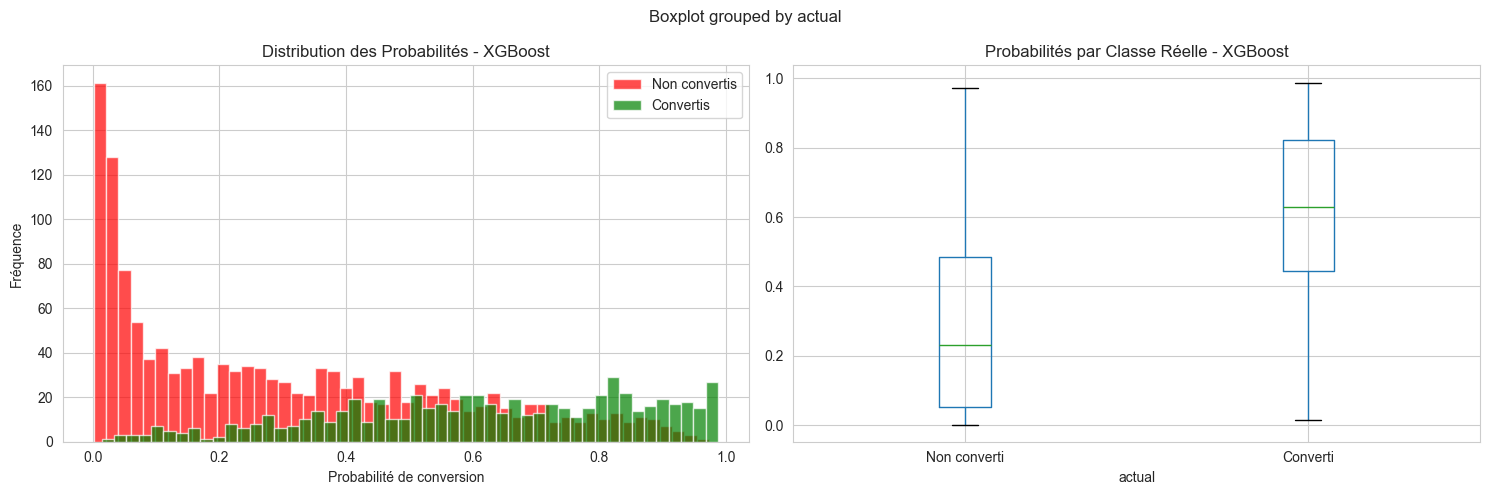


 Faux Positifs: 315 (15.70%)
 Faux Négatifs: 194 (9.67%)

 SEGMENTATION PAR PROBABILITÉ:
         count  sum      mean
segment                      
Low        869   74  0.085155
Medium     741  295  0.398111
High       396  266  0.671717


In [26]:
# Analyse des Prédictions

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_xgb,
    'probability': y_pred_proba_xgb
})

print("="*60)
print("ANALYSE DES PRÉDICTIONS XGBOOST")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des probabilités
axes[0].hist(results_df[results_df['actual']==0]['probability'],
             bins=50, alpha=0.7, label='Non convertis', color='red')
axes[0].hist(results_df[results_df['actual']==1]['probability'],
             bins=50, alpha=0.7, label='Convertis', color='green')
axes[0].set_xlabel('Probabilité de conversion')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Probabilités - XGBoost')
axes[0].legend()

# Boxplot
results_df.boxplot(column='probability', by='actual', ax=axes[1])
axes[1].set_title('Probabilités par Classe Réelle - XGBoost')
axes[1].set_xticklabels(['Non converti', 'Converti'])

plt.tight_layout()
plt.savefig('xgboost_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse des erreurs
false_positives = results_df[(results_df['actual']==0) & (results_df['predicted']==1)]
false_negatives = results_df[(results_df['actual']==1) & (results_df['predicted']==0)]

print(f"\n Faux Positifs: {len(false_positives)} ({len(false_positives)/len(results_df)*100:.2f}%)")
print(f" Faux Négatifs: {len(false_negatives)} ({len(false_negatives)/len(results_df)*100:.2f}%)")

# Segmentation
results_df['segment'] = pd.cut(results_df['probability'],
                                bins=[0, 0.3, 0.7, 1.0],
                                labels=['Low', 'Medium', 'High'])

print("\n SEGMENTATION PAR PROBABILITÉ:")
segment_analysis = results_df.groupby('segment')['actual'].agg(['count', 'sum', 'mean'])
print(segment_analysis)


In [28]:
"""
Utilisation du modèle pour prédire sur de nouveaux utilisateurs
"""

print("="*60)
print("PRÉDICTIONS SUR NOUVEAUX UTILISATEURS")
print("="*60)

# Créer des profils d'utilisateurs types
new_users = pd.DataFrame([
    {
        'time_on_site': 10.5,
        'pages_viewed': 8,
        'source': 'paid',
        'device': 'desktop',
        'hour_of_day': 14,
        'day_of_week': 2,
        'total_events': 15,
        'add_to_cart_count': 3,
        'page_view_count': 8,
        'profile': 'High Value Prospect'
    },
    {
        'time_on_site': 1.2,
        'pages_viewed': 2,
        'source': 'social',
        'device': 'mobile',
        'hour_of_day': 22,
        'day_of_week': 6,
        'total_events': 3,
        'add_to_cart_count': 0,
        'page_view_count': 2,
        'profile': 'Low Engagement'
    },
    {
        'time_on_site': 5.5,
        'pages_viewed': 4,
        'source': 'email',
        'device': 'desktop',
        'hour_of_day': 10,
        'day_of_week': 1,
        'total_events': 8,
        'add_to_cart_count': 1,
        'page_view_count': 4,
        'profile': 'Medium Prospect'
    }
])

# Feature engineering sur les nouveaux utilisateurs
new_users_engineered = engineer_features(new_users.drop('profile', axis=1))

# Encoder les features
new_users_encoded = pd.get_dummies(
    new_users_engineered,
    columns=categorical_features,
    drop_first=True
)

# Normaliser les types booléens
bool_cols_new = new_users_encoded.select_dtypes(include='bool').columns
if len(bool_cols_new) > 0:
    new_users_encoded[bool_cols_new] = new_users_encoded[bool_cols_new].astype(int)

# Aligner les colonnes exactement avec le jeu d'entraînement
training_features = X_train.columns

# Ajouter les colonnes manquantes avec 0
missing_cols = set(training_features) - set(new_users_encoded.columns)
for col in missing_cols:
    new_users_encoded[col] = 0

# Supprimer les colonnes supplémentaires (ex: session_id)
extra_cols = set(new_users_encoded.columns) - set(training_features)
if extra_cols:
    new_users_encoded = new_users_encoded.drop(columns=list(extra_cols))

# Reordonner pour correspondre à l'ordre d'entraînement
new_users_encoded = new_users_encoded[training_features]

# Prédictions
predictions = xgb_model.predict(new_users_encoded)
probabilities = xgb_model.predict_proba(new_users_encoded)[:, 1]

# Afficher les résultats
print("\n RÉSULTATS DES PRÉDICTIONS:\n")
for i, profile in enumerate(new_users['profile']):
    print(f"Profil {i+1}: {profile}")
    print(f"  Caractéristiques:")
    print(f"    • Temps sur site: {new_users.iloc[i]['time_on_site']:.1f} min")
    print(f"    • Pages vues: {new_users.iloc[i]['pages_viewed']}")
    print(f"    • Source: {new_users.iloc[i]['source']}")
    print(f"    • Appareil: {new_users.iloc[i]['device']}")
    print(f"    • Ajouts panier: {new_users.iloc[i]['add_to_cart_count']}")
    print(f"  Prédiction: {' Conversion probable' if predictions[i] == 1 else ' Conversion peu probable'}")
    print(f"  Probabilité: {probabilities[i]:.1%}")

    # Recommandations
    if probabilities[i] < 0.3:
        print(f"   Recommandation: Engagement faible - cibler avec remarketing")
    elif probabilities[i] < 0.7:
        print(f"   Recommandation: Potentiel moyen - offre personnalisée recommandée")
    else:
        print(f"   Recommandation: Fort potentiel - priorité pour contact commercial")
    print()

PRÉDICTIONS SUR NOUVEAUX UTILISATEURS
 Feature Engineering en cours...
 Features créées: 20 features au total

 RÉSULTATS DES PRÉDICTIONS:

Profil 1: High Value Prospect
  Caractéristiques:
    • Temps sur site: 10.5 min
    • Pages vues: 8
    • Source: paid
    • Appareil: desktop
    • Ajouts panier: 3
  Prédiction:  Conversion probable
  Probabilité: 86.8%
   Recommandation: Fort potentiel - priorité pour contact commercial

Profil 2: Low Engagement
  Caractéristiques:
    • Temps sur site: 1.2 min
    • Pages vues: 2
    • Source: social
    • Appareil: mobile
    • Ajouts panier: 0
  Prédiction:  Conversion peu probable
  Probabilité: 31.7%
   Recommandation: Potentiel moyen - offre personnalisée recommandée

Profil 3: Medium Prospect
  Caractéristiques:
    • Temps sur site: 5.5 min
    • Pages vues: 4
    • Source: email
    • Appareil: desktop
    • Ajouts panier: 1
  Prédiction:  Conversion probable
  Probabilité: 90.7%
   Recommandation: Fort potentiel - priorité pour contac

In [ ]:
"""
Sauvegarde du modèle et des artifacts pour utilisation en production
"""

import joblib
from datetime import datetime

print("="*60)
print("SAUVEGARDE DU MODÈLE")
print("="*60)

# Créer un dictionnaire avec tous les composants nécessaires
model_artifacts = {
    'model': xgb_model,
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),  # utiliser exactement les features d'entraînement
    'categorical_features': categorical_features,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1_score': f1_score(y_test, y_pred_xgb),
        'auc_roc': roc_auc_score(y_test, y_pred_proba_xgb)
    },
    'feature_importance': feature_importance_rf
}

# Sauvegarder
model_filename = f'conversion_model_{datetime.now().strftime("%Y%m%d")}.pkl'
joblib.dump(model_artifacts, model_filename)

print(f"\n Modèle sauvegardé: {model_filename}")
print(f"\n Métriques de performance sauvegardées:")
for metric, value in model_artifacts['performance_metrics'].items():
    print(f"  • {metric}: {value:.4f}")

# Test de chargement
print("\n Test de chargement du modèle...")
loaded_artifacts = joblib.load(model_filename)
print(" Modèle chargé avec succès!")

# Vérification
test_prediction = loaded_artifacts['model'].predict(X_test[:5])
print(f" Test de prédiction OK: {test_prediction}")

SAUVEGARDE DU MODÈLE

 Modèle sauvegardé: conversion_model_20251215.pkl

 Métriques de performance sauvegardées:
  • accuracy: 0.7463
  • precision: 0.5833
  • recall: 0.6945
  • f1_score: 0.6341
  • auc_roc: 0.8171

 Test de chargement du modèle...
 Modèle chargé avec succès!
 Test de prédiction OK: [0 0 1 0 0]
